In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors
import multiprocessing
import warnings

from nanonets.utils import BLUE_COLOR, RED_COLOR
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull, KDTree
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.optimize import curve_fit

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="seaborn"
)

plt.style.use(["science","bright","grid"])
PATH    = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/freq_manipulation/fixed_V/"
# PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/f0_1/"

In [2]:
def extract_harmonic_features(y_val, n_vals, N_periods=20, search_range=3, mode='complex', pad_len=None, interpolate=True):
    """
    Extracts harmonic features from a time series using FFT with optional zero-padding
    and parabolic interpolation for high-precision peak estimation.

    Parameters
    ----------
    y_val : array-like
        Input time series (e.g., current or voltage).
    n_vals : list or array-like of int
        List of harmonic orders to extract (e.g., [1, 2, 3] or [3, 5, 7]).
    N_periods : float, optional (default=20)
        Number of full periods of the fundamental frequency contained in y_val.
        Used to identify the theoretical FFT bin index of the fundamental.
    search_range : int, optional (default=3)
        Number of FFT bins to search left/right of the ideal index to account for 
        spectral leakage or small frequency deviations.
    mode : str, optional (default='complex')
        Format of the output features:
        - 'complex':   [Re, Im] pairs relative to fundamental phase. (Length = 2 * len(n_vals))
                       Preserves full shape info; ideal for Volumetric analysis.
        - 'abs':       [Magnitude] only. (Length = len(n_vals))
                       Ideal for THD or Centroid analysis.
        - 'projected': [Magnitude * cos(delta_phi)]. (Length = len(n_vals))
                       Scalar projection onto fundamental axis (lossy).
        - 'phase':     [Phase Difference] in normalized radians/pi [-1, 1].
    pad_len : int or None, optional (default=None)
        Length of the FFT padding. If None, uses len(y_val). 
        Higher values (e.g., 4096) increase spectral density, reducing discretization error.
    interpolate : bool, optional (default=True)
        If True, uses parabolic interpolation on the spectral peak to estimate 
        magnitude and frequency more accurately than the discrete FFT bin resolution.
        Recommended to avoid "bimodality" in error distributions.

    Returns
    -------
    np.ndarray
        Array of feature values. Structure and length depend on 'mode'.
    """
    
    # --- 1. Preprocessing: Detrend and Window ---
    y_val = np.array(y_val)
    # Remove DC offset to prevent 0-Hz peak leakage
    y_val = y_val - np.mean(y_val)
    
    N_samples = len(y_val)
    
    # Blackman window minimizes spectral leakage (low sidelobes)
    window = np.blackman(N_samples)
    y_windowed = y_val * window
    
    # Coherent Gain Correction: compensates for energy amplitude lost due to windowing
    w_gain = np.sum(window) / N_samples
    
    # --- 2. FFT Calculation ---
    # Determine padding
    if pad_len is None:
        n_fft = N_samples
        pad_ratio = 1.0
    else:
        n_fft = pad_len
        pad_ratio = n_fft / N_samples
    
    # rfft is efficient for real-valued inputs; returns positive freqs only
    fft_vals = np.fft.rfft(y_windowed, n=n_fft)

    # Helper: Peak Extraction Logic
    def get_peak_metrics(neighborhood):
        """
        Internal helper to find peak magnitude and phase from a spectral slice.
        Handles both discrete argmax and parabolic interpolation.
        """
        # Safety check for empty or zero-signal neighborhoods
        if len(neighborhood) == 0 or np.max(np.abs(neighborhood)) < 1e-15:
            return 0.0, 0.0

        # Magnitude spectrum of the neighborhood
        mags = np.abs(neighborhood)
        idx_local = np.argmax(mags)
        
        # 1. Discrete Estimates (Base)
        mag_peak = mags[idx_local]
        # Phase at the discrete peak bin
        phase_peak = np.angle(neighborhood[idx_local])
        
        # 2. Parabolic Interpolation (Refinement)
        if interpolate:
            # We need 3 points: (left, center, right)
            # Check bounds to ensure we have neighbors
            if 0 < idx_local < len(mags) - 1:
                alpha = mags[idx_local - 1]
                beta  = mags[idx_local]
                gamma = mags[idx_local + 1]
                
                # Calculate fractional peak shift 'delta' (-0.5 to 0.5)
                # Formula: Parabolic peak location
                denominator = (alpha - 2 * beta + gamma)
                if denominator != 0:
                    delta = 0.5 * (alpha - gamma) / denominator
                    
                    # Refined Magnitude Estimate
                    mag_peak = beta - 0.25 * (alpha - gamma) * delta
                    
                    # Optional: We stick to the discrete bin phase for robustness, 
                    # but the magnitude is now "physics-accurate".

        return mag_peak, phase_peak

    # --- 3. Find Fundamental Phase (Reference Frame) ---
    k_fund_ideal = int(round(1.0 * N_periods * pad_ratio))
    
    # Define search window (scaled by pad_ratio)
    s_width = int(search_range * pad_ratio)
    f_start = max(0, k_fund_ideal - s_width)
    f_end   = min(len(fft_vals), k_fund_ideal + s_width + 1)
    
    fund_neighborhood = fft_vals[f_start:f_end]
    
    # Get Fundamental Metrics
    amp_fund_raw, phi_1 = get_peak_metrics(fund_neighborhood)
    
    # Note: amp_fund_raw is currently in "FFT units". 
    # We don't convert it to physical units yet because we only need phi_1 here.
    # (Though for consistency, it's good to know amp_fund is available).

    features = []

    # Scaling Factor: Convert FFT amplitude to Physical Amplitude
    #   * 2.0: Accounts for negative frequencies dropped by rfft
    #   * / N_samples: Normalization by original signal length (not padded length)
    #   * / w_gain: Correction for window attenuation
    phys_scale = (2.0 / N_samples) / w_gain

    # --- 4. Extract Harmonics ---
    for m in n_vals:
        # Ideal bin for m-th harmonic
        k_ideal = int(round(m * N_periods * pad_ratio))
        
        # Search window
        start = max(0, k_ideal - s_width)
        end   = min(len(fft_vals), k_ideal + s_width + 1)
        
        # Check if harmonic is within Nyquist limit
        if start < len(fft_vals) and start < end:
            neighborhood = fft_vals[start:end]
            
            # Get Harmonic Metrics
            mag_raw, phi_m = get_peak_metrics(neighborhood)
            
            # Convert to Physical Magnitude
            mag = mag_raw * phys_scale
            
            # Phase relative to fundamental (Shift Invariant)
            delta_phi = phi_m - (m * phi_1)
            
            # --- Feature Formatting ---
            if mode == 'complex':
                # Map to 2D plane: (x, y) coordinates
                features.append(mag * np.cos(delta_phi))
                features.append(mag * np.sin(delta_phi))

            elif mode == 'phase':
                # Normalized Wrapped Phase [-1, 1]
                wrapped = (delta_phi + np.pi) % (2 * np.pi) - np.pi
                features.append(wrapped / np.pi)
                
            elif mode == 'projected':
                # Scalar projection onto Real axis
                features.append(mag * np.cos(delta_phi))
                
            else: # mode == 'abs'
                # Pure Magnitude
                features.append(mag)
                
        else:
            # Handle out-of-bounds (e.g., frequencies > Nyquist)
            if mode == 'complex':
                features.extend([0.0, 0.0])
            else:
                features.append(0.0)
                
    return np.array(features)

def MC_effective_volume(points, M_samples, fixed_radius, global_bounds):
    """
    Calculates the 'Effective Volume' of a high-dimensional point cloud using 
    Monte Carlo integration with a fixed probe radius.

    This function estimates the volume of the union of hyperspheres centered at each 
    data point. It is useful for quantifying the "reachable state space" or 
    "expressivity" of a reservoir computer in harmonic space.

    Parameters:
    -----------
    points : np.ndarray
        Array of shape (N_points, D_dimensions) containing the coordinates of the 
        reachable states (e.g., normalized harmonic phasors).
    M_samples : int
        Number of Monte Carlo samples to generate. Higher values reduce variance 
        but increase computation time. Suggest > 100,000 for D > 3.
    fixed_radius : float
        The radius of the hypersphere surrounding each point. This defines the 
        "resolution" of the volume.
        - Small radius: Measures point density (Volume ~ N * V_sphere).
        - Large radius: Approaches the Convex Hull volume (ignoring holes).
    global_bounds : tuple of (np.ndarray, np.ndarray)
        A tuple (min_bounds, max_bounds) defining the hyper-rectangle to sample within.
        Ensure these bounds fully enclose the 'points' + 'fixed_radius' to avoid clipping.

    Returns:
    --------
    float
        The estimated effective volume occupied by the point cloud.
    """
    
    # 1. Setup Bounding Box Dimensions
    min_bounds, max_bounds = global_bounds
    
    # Calculate the side lengths of the sampling box
    # (Vector of length D, allowing for non-cubic bounds)
    side_lengths = max_bounds - min_bounds
    
    # Calculate total volume of the sampling box (V_0)
    # This serves as the reference volume for the Monte Carlo integration
    v0_volume = np.prod(side_lengths)

    # 2. Generate Random Samples (Monte Carlo)
    # Create random points uniformly distributed within the [0, 1] hypercube
    raw_samples = np.random.rand(M_samples, points.shape[1])
    
    # Scale and shift samples to fit inside the 'global_bounds' box
    samples = raw_samples * side_lengths + min_bounds

    # 3. Neighbor Search (The "Hit" Test)
    # Build a KDTree for efficient nearest-neighbor lookup
    tree = KDTree(points)
    
    # Query the tree: Find the distance to the single nearest neighbor for each sample
    # k=1 returns only the nearest neighbor distance
    d_to_nn, _ = tree.query(samples, k=1)
    
    # 4. Count Hits
    # A sample is a "hit" if it falls within 'fixed_radius' of ANY point in the set
    hits = np.sum(d_to_nn <= fixed_radius)

    # 5. Calculate Effective Volume
    # V_eff = (Fraction of Hits) * (Total Box Volume)
    p_hit_rate = hits / M_samples
    v_mc_eff = p_hit_rate * v0_volume

    return v_mc_eff

def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_val = signal - np.mean(signal)
    y_windowed = y_val * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

def data_abundance(y):
    y   = np.asarray(y)
    x   = np.sort(y)
    p_x = 1. * np.arange(len(x)) / float(len(x) - 1)
    ab  = 100 - 100*p_x
    return x, ab

## Paramter and Input Time Series

In [4]:
N_PARTICLES     = [5,13]
N_PERIODS       = 100
N_SAMPLES       = 590
SAMPLE_P_PERIOD = 40
F0              = 28.0
F0_HZ           = F0 * 1e6
AMPLITUDE       = 0.02
U_BOUNDS        = 0.05
N_EQ_PERIODS    = 80
DT              = 1 / (SAMPLE_P_PERIOD * F0_HZ)
T_SIM           = N_PERIODS / F0_HZ
N_STEPS         = int(np.ceil(T_SIM / DT))

### from bagheera

In [5]:
data = {}
for N in tqdm(N_PARTICLES):
    data[N] = []
    for i in range(N_SAMPLES):
        try:
            data[N].append(pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{i}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True))
        except:
            pass

data_new    = {}
error_new   = {}
for N in N_PARTICLES:
    data_new[N]     = [df['Observable'].values*1e-6 for df in data[N]]
    error_new[N]    = [df['Error'].values*1e-6 for df in data[N]]

100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


### from local

In [ ]:
# for N in N_PARTICLES:
#     for i in range(N_SAMPLES):
#         data[N][i].to_csv(f"data/data_uni_{N}_{i}.csv")

In [ ]:
# data        = {}
# data_new    = {}
# error_new   = {}
# for N in N_PARTICLES:
#     data[N]         = {i : pd.read_csv(f"data/data_uni_{N}_{i}.csv") for i in range(N_SAMPLES)}
#     data_new[N]     = [data[N][i]['Observable'].values*1e-6 for i in range(N_SAMPLES)]
#     error_new[N]    = [data[N][i]['Error'].values*1e-6 for i in range(N_SAMPLES)]

## System Size Dependence

### Bootstrapping

In [6]:
# --- Configuration ---
M_samples       = 100_000 
dim             = 5
n_vals          = np.arange(1, dim + 1, 1)
n_bootstraps    = 200
d_factors       = np.logspace(0, 1.5, 21) # The radius sweep

# --- Helper: Worker Function for Parallel Pool ---
def worker_bootstrap_task(args):
    """
    Performs one bootstrap iteration for a specific network size.
    Args packed as tuple: (N_label, points_original, d_factors, base_r, bounds, M, seed)
    """
    N_label, points, factors, ruler, fixed_bounds, M, seed = args
    
    # Seeding ensures reproducibility per process
    rng = np.random.default_rng(seed)
    
    # 1. Resample (Bootstrap with replacement)
    n_pts = len(points)
    idx = rng.integers(0, n_pts, n_pts)
    points_resampled = points[idx]
    
    # 2. Sweep Radii
    curve = []
    for d_factor in factors:
        current_radius = d_factor * ruler
        # Run MC Volume (Assuming MC_effective_volume is defined in your scope)
        v = MC_effective_volume(points_resampled, M, current_radius, fixed_bounds)
        curve.append(v)
        
    return (N_label, np.array(curve))

# --- Main Execution Block ---
if __name__ == "__main__":
    # 1. Feature Extraction (Serial - usually fast enough)
    print("Extracting Harmonic Features...")
    hh_vectors = {}
    all_data_list = []
    
    # Assuming 'N_PARTICLES' and 'data_new' exist in your workspace
    for N in N_PARTICLES:
        vecs = np.array([extract_harmonic_features(data_new[N][i], n_vals, mode='complex', pad_len=8192, interpolate=True) 
                         for i in range(len(data_new[N]))])
        
        # Normalize
        vecs_norm = vecs / vecs[:, 0, np.newaxis]
        features = vecs_norm[:, 2:] 
        hh_vectors[N] = features
        all_data_list.append(features)

    # 2. Global Ruler Calculation (Must be done ONCE on ALL data)
    print("Calculating Global Base Radius...")
    all_data_stacked = np.vstack(all_data_list)
    
    if len(all_data_stacked) > 10_000:
        idx_sub = np.random.choice(len(all_data_stacked), 10_000, replace=False)
        dist_subset = all_data_stacked[idx_sub]
    else:
        dist_subset = all_data_stacked

    base_radius_unit = np.median(pdist(dist_subset))
    print(f"Base Radius Unit: {base_radius_unit:.4f}")

    # 3. Prepare Parallel Tasks
    tasks = []
    print(f"Preparing {len(N_PARTICLES) * n_bootstraps} tasks...")
    
    for N in N_PARTICLES:
        points = hh_vectors[N]
        
        # Define Fixed Bounds for this N (based on original data to keep consistent frame)
        sys_min = points.min(axis=0)
        sys_max = points.max(axis=0)

        box_min = sys_min - (base_radius_unit * 2.0)
        box_max = sys_max + (base_radius_unit * 2.0)
        bounds = (box_min, box_max)
        
        # Create tasks for this N
        for b in range(n_bootstraps):
            # Generate a unique seed for each worker to avoid identical random streams
            seed = np.random.randint(0, 10**9)
            task = (N, points, d_factors, base_radius_unit, bounds, M_samples, b)
            tasks.append(task)

    # 4. Run Parallel Pool
    # Use all available cores minus 1 to keep system responsive
    n_cores = max(1, multiprocessing.cpu_count() - 1)
    print(f"Starting Pool with {n_cores} workers...")
    
    results_agg = {N: [] for N in N_PARTICLES}
    
    with multiprocessing.Pool(n_cores) as pool:
        # map_async + tqdm (optional) or just simple map
        results = pool.map(worker_bootstrap_task, tasks)
        
    # 5. Aggregate Results
    for N_label, curve in results:
        results_agg[N_label].append(curve)

    # 6. Compute Stats & Plot
    print("Processing Statistics...")
    import matplotlib.pyplot as plt
    
    V_eff_stats = {}
    for i, N in enumerate(N_PARTICLES):
        # Shape: (n_bootstraps, n_d_factors)
        curves_matrix = np.array(results_agg[N])
        
        mean_curve = np.mean(curves_matrix, axis=0)
        std_curve  = np.std(curves_matrix, axis=0)
        
        V_eff_stats[N] = {'mean': mean_curve, 'std': std_curve}

Extracting Harmonic Features...
Calculating Global Base Radius...
Base Radius Unit: 0.1407
Preparing 400 tasks...
Starting Pool with 19 workers...
Processing Statistics...


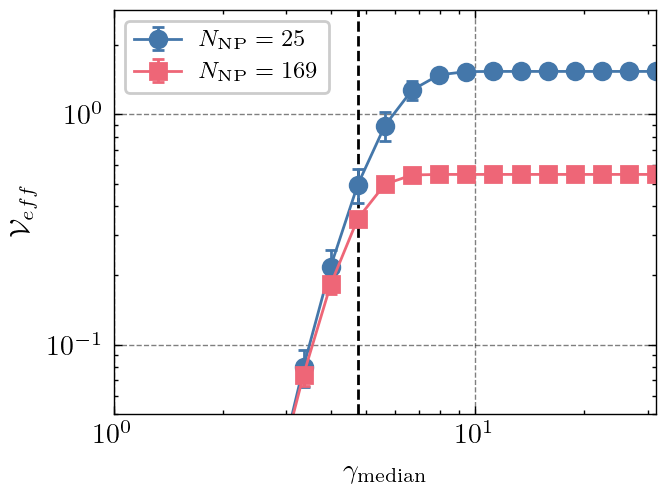

In [9]:
d_idx   = 9
mss     = ['o','s','P','^','v','<','>']
fig, ax = plt.subplots(dpi=200)
for i, N in enumerate(N_PARTICLES):
    _   = ax.errorbar(d_factors, V_eff_stats[N]['mean'], V_eff_stats[N]['std']*1.96, label="$N_\\textrm{NP} = "+f"{N**2}$", capsize=2, marker=mss[i])
_   = ax.set_xlim(d_factors[0], d_factors[-1])
_   = plt.axvline(d_factors[d_idx], color='black', ls='--', zorder=0.1)
_   = ax.set_xlabel("$\gamma_\\textrm{median}$")
_   = ax.set_xscale('log')
_   = ax.set_ylabel("$\mathcal{V}_{eff}$")
_   = ax.legend(fontsize='small', loc='upper left')
_   = ax.set_yscale('log')
_   = ax.set_ylim(5e-2)

# fig.savefig(f"plots/png/V_eff_vs_gamma_median_system_size.png", transparent=False)
# fig.savefig(f"plots/pdf/V_eff_vs_gamma_median_system_size.pdf", transparent=False)
# fig.savefig(f"plots/svg/V_eff_vs_gamma_median_system_size.svg", transparent=True)

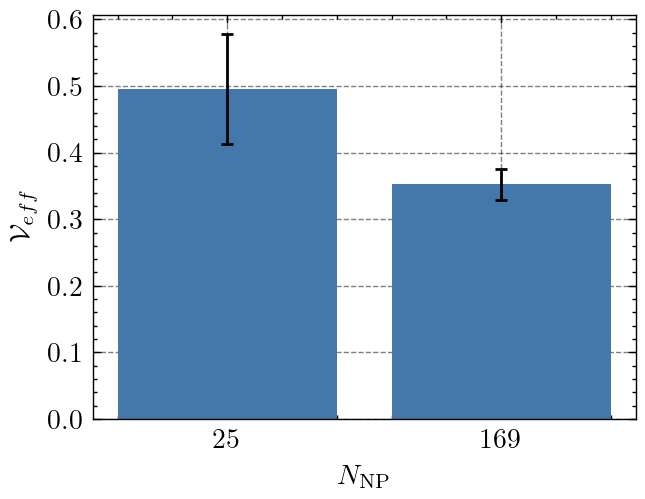

In [18]:
def power_law(x, a, c):
    return a*(x)**c

fig, ax = plt.subplots(dpi=200)
_       = ax.bar(x=["25","169"], height=[V_eff_stats[N]['mean'][d_idx] for N in N_PARTICLES],
                      yerr=[V_eff_stats[N]['std'][d_idx]*1.96 for N in N_PARTICLES], capsize=2)
_       = ax.set_xlabel("$N_\\textrm{NP}$")
_       = ax.set_ylabel("$\mathcal{V}_{eff}$")

# fig.savefig(f"plots/png/V_eff_vs_system_size.png", transparent=False)
# fig.savefig(f"plots/pdf/V_eff_vs_system_size.pdf", transparent=False)
# fig.savefig(f"plots/svg/V_eff_vs_system_size.svg", transparent=True)

### Phase

In [19]:
samples_p_N = {N : len(data_new[N]) for N in N_PARTICLES}
samples_p_N

{5: 590, 13: 589}

In [20]:
N_BOOT    = 50
data_boot = {}
for N in N_PARTICLES:
    data_boot[N] = []
    for i in range(samples_p_N[N]):
        for _ in range(N_BOOT):
            data_boot[N].append(data_new[N][i]+np.random.normal(0,error_new[N][i]))

In [21]:
# --- Configuration ---
phase_vectors   = {}
amp_vectors     = {}
dim             = 5
n_vals          = np.arange(2, dim + 1, 1)

# Get Phase
for N in N_PARTICLES:
    phase_vectors[N] = np.array([extract_harmonic_features(data_boot[N][i], n_vals, mode='phase', pad_len=8192, interpolate=True) 
                     for i in range(samples_p_N[N]*N_BOOT)])
    amp_vectors[N] = np.array([extract_harmonic_features(data_boot[N][i], n_vals, mode='abs', pad_len=8192, interpolate=True) 
                     for i in range(samples_p_N[N]*N_BOOT)])

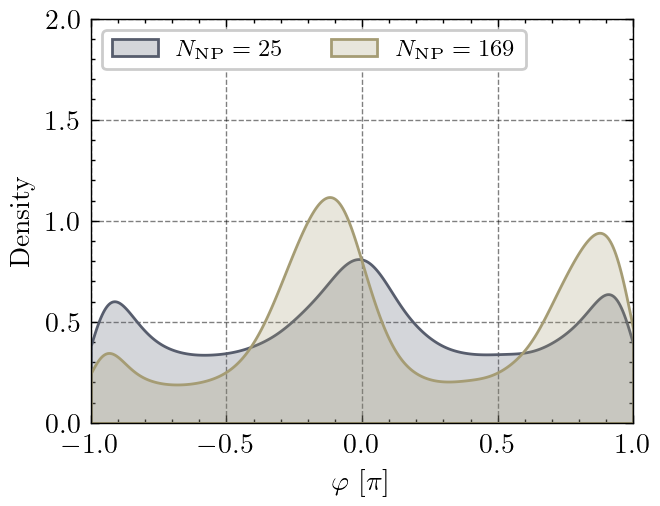

In [22]:
cp      = sns.color_palette('cividis', n_colors=len(N_PARTICLES))
fig, ax = plt.subplots(dpi=200)
for i, N in enumerate(N_PARTICLES):
    df  = pd.DataFrame({'a':phase_vectors[N].flatten(),'b':amp_vectors[N].flatten()})
    ax  = sns.kdeplot(data=df, x='a', ax=ax, weights='b', cut=0, fill=True, bw_adjust=1.0, gridsize=400, color=cp[i])

_ = ax.set_xlabel("$\\varphi~[\mathrm{\pi}]$")
_ = ax.set_xlim(-1,1)
_ = ax.set_ylim(0,2)

leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles, labels, fontsize='small', loc='upper left', ncol=2)

# fig.savefig(f"plots/png/phase_vs_size.png", transparent=False)
# fig.savefig(f"plots/pdf/phase_vs_size.pdf", transparent=False)
# fig.savefig(f"plots/svg/phase_vs_size.svg", transparent=True)

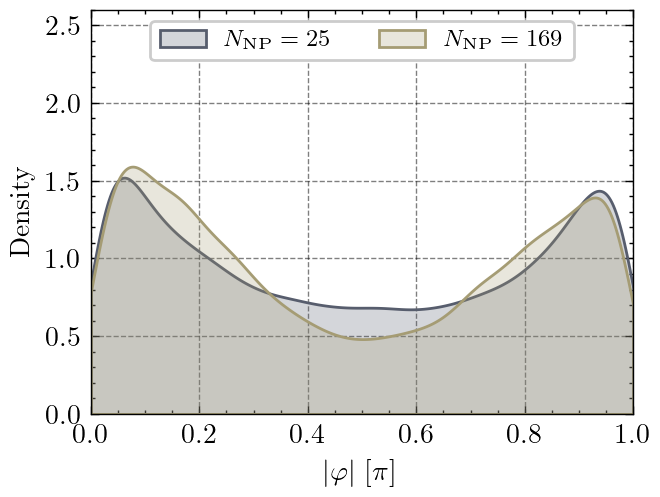

In [23]:
fig, ax = plt.subplots(dpi=200)
for i, N in enumerate(N_PARTICLES):
    df  = pd.DataFrame({'a':np.abs(phase_vectors[N].flatten()),'b':amp_vectors[N].flatten()})
    ax  = sns.kdeplot(data=df, x='a', ax=ax, weights='b', cut=0, fill=True, bw_adjust=1.0, gridsize=400, color=cp[i])

_ = ax.set_xlabel("$|\\varphi|~[\mathrm{\pi}]$")
_ = ax.set_xlim(0,1)
_ = ax.set_ylim(0,2.6)

leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles, labels, fontsize='small', loc='upper center', ncol=2)

# fig.savefig(f"plots/png/abs_phase_vs_size.png", transparent=False)
# fig.savefig(f"plots/pdf/abs_phase_vs_size.pdf", transparent=False)
# fig.savefig(f"plots/svg/abs_phase_vs_size.svg", transparent=True)

### Nonlinear Metrics

In [24]:
hh_vectors  = {}
dim         = 9
d_factors   = np.logspace(-1,1,31)
n_vals      = np.arange(1,dim+1,1)
noise_floor = 1
for N in N_PARTICLES:
    hh_vectors[N] = np.array([extract_harmonic_features(data_boot[N][i],n_vals,mode='abs',pad_len=8192,interpolate=True) for i in range(samples_p_N[N]*N_BOOT)])

centr_vals  = {N : [compute_spectral_centroid(hh_vectors[N][i], n_vals) for i in range(samples_p_N[N]*N_BOOT) if hh_vectors[N][i,0] > noise_floor] for N in N_PARTICLES}
thd_vals    = {N : [compute_thd(hh_vectors[N][i]) for i in range(samples_p_N[N]*N_BOOT) if hh_vectors[N][i,0] > noise_floor] for N in N_PARTICLES}

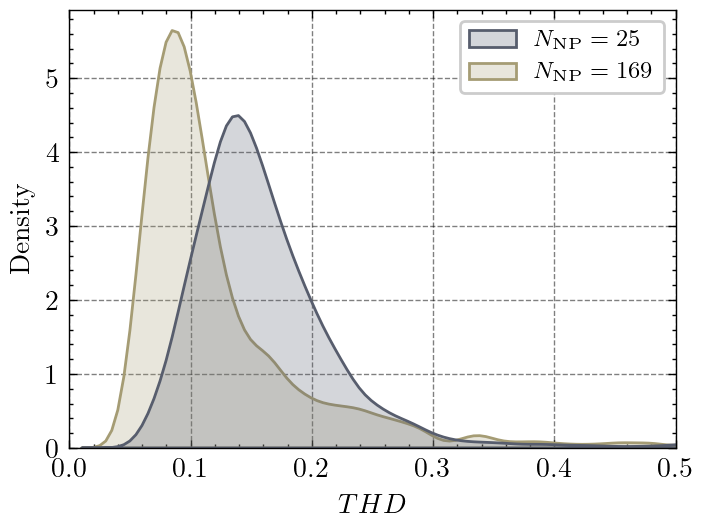

In [25]:
mss = ['o','s','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.kdeplot(thd_vals, log_scale=False, palette='cividis', fill=True, ax=ax, common_grid=True, bw_adjust=1.0, clip=(0,1.0))
_   = ax.set_xlabel('$THD$')
_   = ax.set_xlim(0.0, 0.5)
# _   = ax.set_xscale('log')

# Legend Shit
leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES[::-1]])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles[::-1], labels[::-1], fontsize='small', loc='upper right', ncol=1)

# fig.savefig("plots/png/THD_dist_vs_system_size.png", transparent=False)
# fig.savefig("plots/pdf/THD_dist_vs_system_size.pdf", transparent=False)
# fig.savefig("plots/svg/THD_dist_vs_system_size.svg", transparent=True)

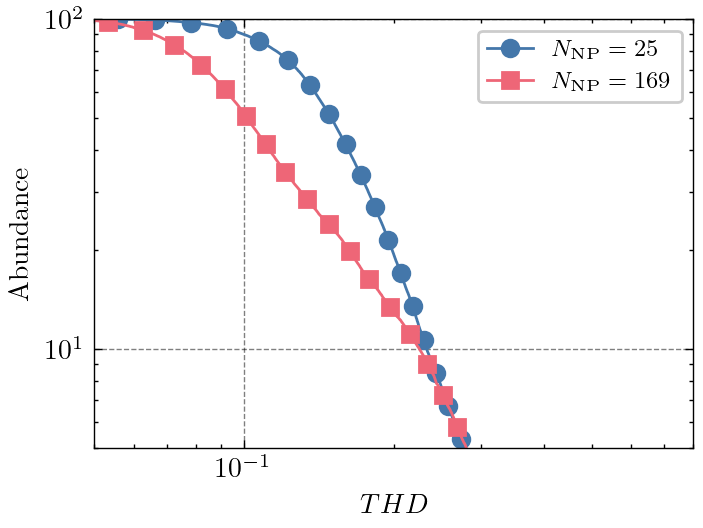

In [26]:
cp  = sns.color_palette('cividis', n_colors=len(thd_vals.keys()))
mss = ['o','s','P','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
for i, (key, val) in enumerate(thd_vals.items()):
    x, ab   = data_abundance(val)
    _       = ax.plot(x, ab, label="$N_\\textrm{NP} = "+f"{key**2}$", marker=mss[i], markevery=0.05)#, c=cp[i])
_   = ax.legend(fontsize='small', ncol=1, loc='upper right')
_   = ax.set_xlabel('$THD$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(0.05,0.8)
_   = ax.set_ylim(5,100)
_   = ax.set_xscale('log')
_   = ax.set_yscale('log')

# fig.savefig("plots/png/THD_abundance_vs_system_size.png", transparent=False)
# fig.savefig("plots/pdf/THD_abundance_vs_system_size.pdf", transparent=False)
# fig.savefig("plots/svg/THD_abundance_vs_system_size.svg", transparent=True)

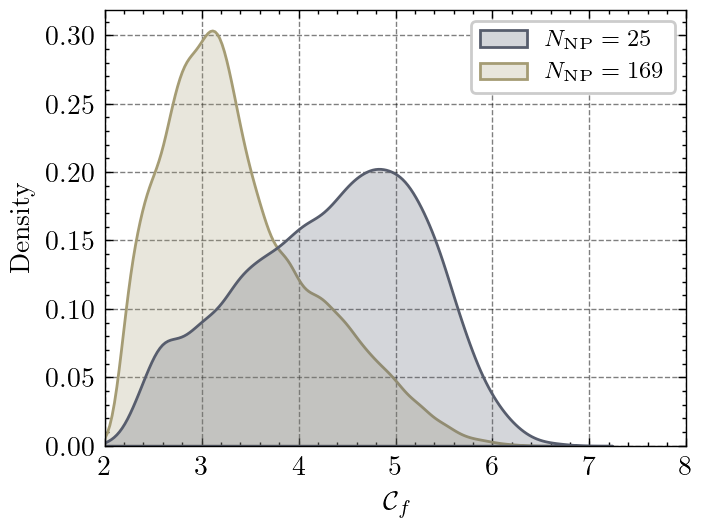

In [27]:
mss = ['o','s','P','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.kdeplot(centr_vals, log_scale=False, palette='cividis', fill=True, ax=ax)
_   = ax.set_xlabel('$\mathcal{C}_f$')
_   = ax.set_xlim(2,8)

# Legend Shit
leg     = ax.legend(["$N_\\textrm{NP} ="+f" {N*N}$" for N in N_PARTICLES[::-1]])
handles = leg.legend_handles
labels  = [t.get_text() for t in leg.get_texts()]
ax.legend(handles[::-1], labels[::-1], fontsize='small', loc='upper right', ncol=1)

# fig.savefig("plots/png/Cf_dist_vs_system_size.png", transparent=False)
# fig.savefig("plots/pdf/Cf_dist_vs_system_size.pdf", transparent=False)
# fig.savefig("plots/svg/Cf_dist_vs_system_size.svg", transparent=True)

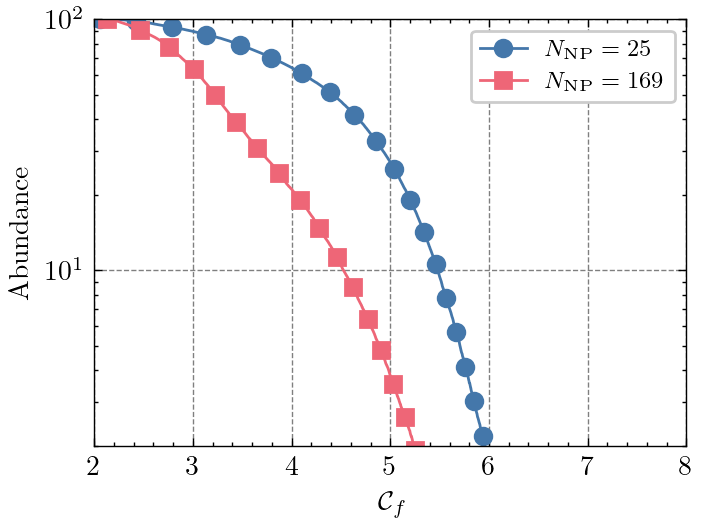

In [28]:
mss = ['o','s','P','^','v','<','>']
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
for i, (key, val) in enumerate(centr_vals.items()):
    x, ab   = data_abundance(val)
    _       = ax.plot(x, ab, label="$N_\\textrm{NP} = "+f"{key**2}$", marker=mss[i], markevery=0.05)
_   = ax.legend(fontsize='small', ncol=1, loc='upper right')
_   = ax.set_xlabel('$\mathcal{C}_f$')
_   = ax.set_ylabel('Abundance')
_   = ax.set_xlim(2,8)
_   = ax.set_ylim(2,100)
_   = ax.set_yscale('log')

# fig.savefig("plots/png/Cf_abundance_vs_system_size.png", transparent=False)
# fig.savefig("plots/pdf/Cf_abundance_vs_system_size.pdf", transparent=False)
# fig.savefig("plots/svg/Cf_abundance_vs_system_size.svg", transparent=True)